In [1]:
import tensorflow as tf
import torch
import random
import os
import pathlib
import time
import datetime
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
import tensorflow.keras.backend as K
from sklearn.preprocessing import OneHotEncoder
tf.config.run_functions_eagerly(True)


In [2]:
#change current directory up to parent (since the data is there), only run 1 time!
os.chdir("..")

# Load data

In [3]:
def load_data(test=False,Print=False,path=f'{os.path.abspath(os.curdir)}/data/carseg_data/clean_data',nr_img=1498):
    train_data_input=[]
    train_data_target=[]
    
    for n in range(nr_img):
        n1=n
        if test:
            n1=f'{n}_a'
        try:
            test1=np.load(f'{path}/{n1}.npy')
            inputs=test1[:3].transpose()
            inputs=tf.convert_to_tensor(inputs)
            inputs=inputs[tf.newaxis,...]
            target=test1[3].transpose()
            target=tf.convert_to_tensor(target)
            target=target[...,tf.newaxis]
            target=target[tf.newaxis,...]

            
            train_data_input.append(inputs)
            train_data_target.append(target)
        except:
            if Print:
                print(f'fil nr {n} mangeler')
    return [train_data_input,train_data_target]

In [4]:
#Defining test and train
test_data=load_data(test=True)
train_data=load_data()

In [5]:
#Checking dimensions
def Get_stats(data):
    print(f'Number of training img {len(data[0])}')
    print(f'target sahpe {data[1][0].shape}')
    print(f'input shape {data[0][0].shape}')

print('test_data:')
Get_stats(test_data)
print('train_data:')
Get_stats(train_data)

test_data:
Number of training img 99
target sahpe (1, 256, 256, 1)
input shape (1, 256, 256, 3)
train_data:
Number of training img 1128
target sahpe (1, 256, 256, 1)
input shape (1, 256, 256, 3)


#  One-hot encoding


In [6]:
depth = 8 #8 classes
test_data2=tf.one_hot(test_data[1], depth)[:,:,:,:,0,:]
train_data2=tf.one_hot(train_data[1], depth)[:,:,:,:,0,:]
test_data[1]=test_data2
train_data[1]=train_data2

In [7]:
#Checking dimensions
print('test_data:')
Get_stats(test_data)
print('train_data:')
Get_stats(train_data)

test_data:
Number of training img 99
target sahpe (1, 256, 256, 8)
input shape (1, 256, 256, 3)
train_data:
Number of training img 1128
target sahpe (1, 256, 256, 8)
input shape (1, 256, 256, 3)


# Buiding the generator

In [8]:
#defining the encoder
def downsample(filters, size, apply_batchnorm=True,stride=2):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=stride, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [9]:
#defining the decoder
def upsample(filters, size, apply_dropout=False,stride=2):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=stride,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [10]:
#U-net This is on exampel of a Unet struckter 
def Generator1():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(8, (3,3), apply_batchnorm=False,stride=1),  
    downsample(8, (3,3),stride=1),
    downsample(8, (3,3)),
    downsample(16, (3,3),stride=1),  
    downsample(16, (3,3),stride=1),  
    downsample(16, (3,3)),  
    downsample(32, (3,3),stride=1),  
    downsample(32, (3,3),stride=1),  
    downsample(32, (3,3)),  
      
    downsample(64, (3,3),stride=1),
    downsample(64, (3,3),stride=1),
    downsample(64, (3,3)),
      
    downsample(128, (3,3),stride=1), 
    downsample(128, (3,3),stride=1),  
    downsample(8, (3,3),stride=1), 
      
  ]

  up_stack = [
    upsample(32, (2,2),stride=2),  
    downsample(32, (3,3),stride=1),  
    downsample(32, (3,3),stride=1), 

    
    upsample(32, (2,2),stride=2),  
    downsample(32, (3,3),stride=1), 
    downsample(32, (3,3),stride=1),  
      
    upsample(16, (2,2),stride=2),  
    downsample(16, (3,3),stride=1),  
    downsample(16, (3,3),stride=1),  
    
    upsample(8, (2,2),stride=2),  
    downsample(8, (3,3),stride=1),  
    downsample(8, (3,3),stride=1), 
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  OUTPUT_CHANNELS=8
  softlayer=tf.keras.layers.Softmax(axis = -1)


  x = inputs
    
  x=tf.keras.layers.Dropout(0.5)(x)


  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])
  print(skips)
  x=tf.keras.layers.Flatten()(x)
  x=tf.keras.layers.Dropout(0.5)(x)
  x=tf.keras.layers.Dense(256)(x)
  x=tf.keras.layers.Dropout(0.5)(x)
  x=tf.keras.layers.Dense(512)(x)
  x=tf.keras.layers.Reshape((16,16,2))(x)
  
  
  # Upsampling and establishing the skip connections
  n=0
  conc=[1,4,7,10,13]
  for up, skip in zip(up_stack, skips):
    n+=1
    if n in conc:
        x = tf.keras.layers.Concatenate()([x, skip])
    x = up(x)
  x = softlayer(x)
  return tf.keras.Model(inputs=inputs, outputs=x)

In [11]:
#Constructing U-net
generator1 = Generator1()
#Plotting the model
tf.keras.utils.plot_model(generator1, show_shapes=True, dpi=64)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [12]:
#Another U-net that we have tested 
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 2, apply_batchnorm=False),  
    downsample(128, 3),
    downsample(128, 2),
    downsample(256, 2),  
    downsample(512, 3),  
    downsample(512, 3),  
    downsample(512, 2),  
  ]

  up_stack = [
    upsample(512, 3, apply_dropout=True),  
    upsample(512, 2),  
    upsample(256, 2), 
    upsample(128, 3),
    upsample(128, 2),
    upsample(64, 2),  
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  OUTPUT_CHANNELS=8
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  
  softlayer=tf.keras.layers.Softmax(axis = -1)


  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)
  
  x = softlayer(x)
  #x = tf.math.argmax(x, axis = -1)[...,tf.newaxis]
  return tf.keras.Model(inputs=inputs, outputs=x)

In [13]:
#Constructing U-net
generator = Generator()
#Plotting the model
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [14]:
#print(test_data[0][0].shape)
gen_output = generator(test_data[0][0], training=False)
#print(gen_output.shape)
#gen_output = tf.math.argmax(gen_output, axis = -1)[...,tf.newaxis]
#print(gen_output.shape)
#plt.imshow(gen_output[0, ...])
#print(gen_output)

# Loss

In [15]:
#finding DICE 
def dice_coef(y_true, y_pred, smooth=0):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice


In [16]:
#loss function with  DICE
def generator_loss(gen_output, target):

  #DICE
  dice=1-dice_coef(target,gen_output)

  return dice

In [17]:
#Defining an optimizer using Adam
generator_optimizer = tf.keras.optimizers.Adam(2e-3, beta_1=0.5)

In [18]:
#Plotting images during training
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))
  #print(prediction[0])
  display_list = [test_input[0], tf.argmax(tar[0],axis=-1),tf.argmax(prediction[0],axis=-1) ]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i]) #* 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [19]:
#Plotting loss during training
def generate_loses(loses):

    title = ['dice loss']
    plt.title(title[0])
    plt.plot(loses[1:])
    
    plt.show()

In [20]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [21]:
@tf.function
def train_step(input_image, target, step,unet=True):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    #generate an output
    gen_output = generator(input_image, training=True)
    
    #Calculating the loss
    dice = generator_loss(gen_output, target)
  
  #Calculating the gradients of loss
  generator_gradients = gen_tape.gradient(dice,
                                          generator.trainable_variables)
  #Applying the gradients to the optimizer
  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  #saving the losees to plot later
  losees=np.array(dice.numpy())
  with summary_writer.as_default():
    tf.summary.scalar('dice_loss', dice, step=step//1000)
  return losees

In [22]:
#Training loop
def fit(train_ds, test_ds, steps,batch_size=4):
  #get random nr so we can test plot on that idx
  randomnr=random.randint(0,len(test_ds[0])-1)  
  example_input, example_target=test_ds[0][randomnr],test_data[1][randomnr]

  start = time.time()
  #array that contains the lorses for eache step
  losees=np.array([0])
  #take x steps of the train_step function with a random img as input
  for step in range(steps):
    r1=random.randint(0,len(train_ds[0])-1)
    input_image=train_ds[0][r1]
    target=train_ds[1][r1]
    for n in range(batch_size-1):  
        r2=random.randint(0,len(train_ds[0])-1)
        input_image2=train_ds[0][r1]
        target2=train_ds[1][r1]
        input_image=tf.concat([input_image2,input_image],0)
        target=tf.concat([target2,target],0)
    
    #Clearing the output and run generate images every 10 steps
    if(step) % 10 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 10 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      generate_loses(losees)
      print(f"Step: {step}")
    l=train_step(input_image, target, step)
    losees=np.append(losees,np.array([l]),axis=0)  
      
  
    # Printing a dot (.) every 10 steps
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    #if (step + 1) % 5000 == 0:
      #checkpoint.save(file_prefix=checkpoint_prefix)

Time taken for 10 steps: 4.32 sec



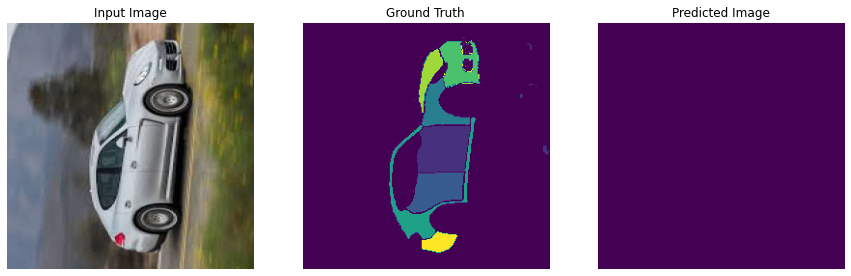

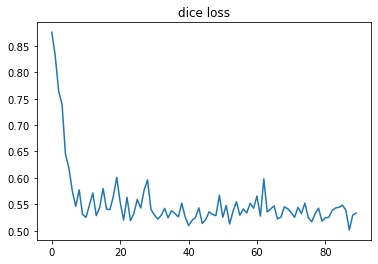

Step: 90
.

In [23]:
fit(train_data, test_data, steps=100)